# Initial Setup

In [1]:
import os
import copy as copy
from math import pi

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Input, Convolution2D, MaxPooling2D

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.palettes import Category20c
from bokeh.transform import cumsum

pd.set_option("display.max_columns", 42)
pd.options.plotting.backend = 'hvplot'
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

# Utils

In [9]:
# Paths de los datos a utilizar (directorio de las imagenes y csv): CAMBIAR CON LOS QUE CORRESPONDAN

# IMAGES_PATH = "D:\Documents\Machine Learning\TP3\imagenes_tp3_cv"
# IMAGES_TARGET_PATH = "D:\Documents\Machine Learning\TP3\list_attr_celeba.csv"
# IMAGES_PARTITION_PATH = "D:\Documents\Machine Learning\TP3\list_eval_partition.csv"

IMAGES_PATH = r"C:\Users\agus_\Desktop\ML_Grupo_2\imagenes_tp3_cv"
IMAGES_TARGET_PATH = r"C:\Users\agus_\Desktop\ML_Grupo_2\data\raw\list_attr_celeba.csv"
IMAGES_PARTITION_PATH = r"C:\Users\agus_\Desktop\ML_Grupo_2\data\raw\list_eval_partition.csv"

# Porcentaje de datos con los que me voy a quedar de los conjuntos train, test y validation originales
GLOBAL_FRAC = 0.05

# Datos generales
N_COLORS = 3
HEIGHT = 218
WIDTH = 178

INPUT_COLUMNS = N_COLORS * HEIGHT * WIDTH

# Danger zone

In [115]:
df_images_target = pd.read_csv(IMAGES_TARGET_PATH, sep=',', decimal=',', encoding='utf-8')
df_images_partition = pd.read_csv(IMAGES_PARTITION_PATH, sep=',', decimal=',', encoding='utf-8')

In [116]:
df_images_target = df_images_target.replace(-1, 0)

df_images_partition.set_index('image_id', inplace=True)
df_images_target.set_index('image_id', inplace=True)
df_images_target["partition"] = df_images_partition["partition"]

df_train = df_images_target[df_images_target.partition == 0].sample(frac=GLOBAL_FRAC, random_state=1)
df_test = df_images_target[df_images_target.partition == 1].sample(frac=GLOBAL_FRAC, random_state=1)

print(len(df_train), len(df_test))

8138 993


In [117]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

df_train['Smiling'] = df_train['Smiling'].astype(str)
df_test['Smiling'] = df_test['Smiling'].astype(str)

df_train = df_train[['image_id', 'Smiling']]
df_test = df_test[['image_id', 'Smiling']]

In [119]:
# Needs a string output column 

print(df_train.dtypes.loc['Smiling'], df_test.dtypes.loc['Smiling'])

object object


In [120]:
from keras.preprocessing.image import ImageDataGenerator

**TRAIN**

In [134]:
data_gen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = data_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_PATH,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32, 
    shuffle=True,
    seed=1,
    target_size=(70,70)
)

Found 8138 validated image filenames belonging to 2 classes.


In [139]:
X, y = train_generator.next()

In [140]:
X.shape

(32, 70, 70, 3)

In [141]:
X

array([[[[0.09019608, 0.09411766, 0.07450981],
         [0.09019608, 0.09411766, 0.07450981],
         [0.10196079, 0.10588236, 0.08627451],
         ...,
         [0.07843138, 0.08235294, 0.05882353],
         [0.07843138, 0.08235294, 0.05882353],
         [0.06666667, 0.08627451, 0.05882353]],

        [[0.09019608, 0.09411766, 0.07450981],
         [0.09019608, 0.09411766, 0.07450981],
         [0.10196079, 0.10588236, 0.08627451],
         ...,
         [0.07843138, 0.08235294, 0.05882353],
         [0.07843138, 0.08235294, 0.05882353],
         [0.07450981, 0.08627451, 0.05882353]],

        [[0.09019608, 0.09411766, 0.07450981],
         [0.09019608, 0.09411766, 0.07450981],
         [0.10196079, 0.10588236, 0.08627451],
         ...,
         [0.07843138, 0.08235294, 0.05882353],
         [0.07843138, 0.08235294, 0.05882353],
         [0.07843138, 0.08235294, 0.05882353]],

        ...,

        [[0.15294118, 0.15294118, 0.14509805],
         [0.18039216, 0.18039216, 0.17254902]

**TEST ("Validation")**

In [135]:
validation_generator = data_gen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_PATH,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32, 
    shuffle=True,
    seed=1,
    target_size=(70,70)
)

Found 993 validated image filenames belonging to 2 classes.


**MODEL**

Aca hay que poner un "flatten" pero no se como funciona ni tampoco me deja

In [157]:
MLP_model = Sequential([
    Flatten(input_shape=(70, 70, 3)), #<- No se si va aca, si lo pones despues de la primer layer rompe
    Dense(200, activation='relu'),

    Dense(100, activation='relu'),
    Dropout(0.2),
    
    Dense(50, activation='relu'),
    Dropout(0.2),
    
    Dense(20, activation='relu'),
    Dropout(0.2),
    
    Dense(10, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

MLP_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [158]:
MLP_model.fit(train_generator, 
              epochs=10, 
              workers=4, 
              validation_data=validation_generator
)

Epoch 1/10
255/255 [==============================] - 35s 139ms/step - loss: 0.7661 - accuracy: 0.4968 - val_loss: 0.7199 - val_accuracy: 0.4995
Epoch 2/10
255/255 [==============================] - 21s 82ms/step - loss: 0.7022 - accuracy: 0.4956 - val_loss: 0.6838 - val_accuracy: 0.4995
Epoch 3/10
255/255 [==============================] - 20s 79ms/step - loss: 0.6956 - accuracy: 0.4986 - val_loss: 0.6862 - val_accuracy: 0.5005
Epoch 4/10
255/255 [==============================] - 20s 79ms/step - loss: 0.6935 - accuracy: 0.5141 - val_loss: 0.6818 - val_accuracy: 0.5015
Epoch 5/10
255/255 [==============================] - 20s 79ms/step - loss: 0.6933 - accuracy: 0.5257 - val_loss: 0.6707 - val_accuracy: 0.5589
Epoch 6/10
255/255 [==============================] - 21s 83ms/step - loss: 0.6855 - accuracy: 0.5319 - val_loss: 0.5166 - val_accuracy: 0.6798
Epoch 7/10
255/255 [==============================] - 20s 80ms/step - loss: 0.5831 - accuracy: 0.6805 - val_loss: 0.1753 - val_accuracy

# ------------------------------------------------------------

In [10]:
def get_train_test_validation(total=False):
    df_images_target = pd.read_csv(IMAGES_TARGET_PATH, sep=',', decimal=',', encoding='utf-8')
    df_images_target.columns = df_images_target.columns.str.lower()
    df_images_target.set_index('image_id', inplace=True)
    
    df_images_target = df_images_target.replace(-1, 0)
    
    df_images_partition = pd.read_csv(IMAGES_PARTITION_PATH, sep=',', decimal=',', encoding='utf-8')
    # df_images_partition.columns = df_images_partition.columns.str.lower()
    df_images_partition.set_index('image_id', inplace=True)
    
    df_images_target["partition"] = df_images_partition["partition"]
    
    df_train = df_images_target[df_images_target.partition == 0].sample(frac=GLOBAL_FRAC, random_state=1)
    df_test = df_images_target[df_images_target.partition == 1].sample(frac=GLOBAL_FRAC, random_state=1)
    df_validation = df_images_target[df_images_target.partition == 2].sample(frac=GLOBAL_FRAC, random_state=1)
    
    if total:
        return pd.concat([df_train, df_test, df_validation])
    return df_train[["smiling"]], df_test[["smiling"]], df_validation[["smiling"]]

In [11]:
def get_images(df):
    images = []
    images_target = []
    
    for filename in df.index.values.tolist():
        img = Image.open(os.path.join(IMAGES_PATH,filename))
        img_numpy = np.asarray(img)
        images.append(img_numpy)
        
        images_target.append(df[df.index == filename].smiling.values[0])
    return images, images_target

In [12]:
def make_data_volume(df, part, tot=False):
    if tot:
        _df = df.copy()
    else:
        _df = df[df.partition == part].copy()
    
    _df.drop('partition', axis=1, inplace=True)
    _df = _df.apply(pd.Series.value_counts)
    _df.rename(index={0: 'No', 1: 'Yes'}, inplace=True)
    return _df.T

# Read data

**Lectura del set de datos con el que se trabajará**

In [13]:
p = round(GLOBAL_FRAC*100, 2)
print("Debido a la cantidad elevada de imagenes, a las limitaciones de hardware y al reducido tiempo para las pruebas,")
print(f"se trabajará con una fracción del dataset original. Este corresponde al {p}% del mismo.")

Debido a la cantidad elevada de imagenes, a las limitaciones de hardware y al reducido tiempo para las pruebas,
se trabajará con una fracción del dataset original. Este corresponde al 5.0% del mismo.


In [14]:
# Se obtienen los datos que se usarán en el trabajo (total=True)
df_data = get_train_test_validation(total=True)

**División del set de datos**

Se obtienen dos arrays para cada set de datos (train, test, validation):

* X_images: array de numpy que representa a cada imagen.
* X_target: array que cuenta con el target (si sonríe o no) para cada una de las imagenes anteriores.

*Anotación: "X" hace referencia al set correspondiente (train, test o validation)*

In [8]:
# Se obtienen los datos corresponidentes a los conjuntos de train, test y validation
df_train, df_test, df_validation = get_train_test_validation()

In [7]:
%%time
train_images, train_target = get_images(df_train)

Wall time: 1min 30s


In [8]:
%%time
test_images, test_target = get_images(df_test)

Wall time: 17 s


In [9]:
%%time
validation_images, validation_target = get_images(df_validation)

Wall time: 37.3 s


**Ejemplos de las imágenes que estaremos usando:**

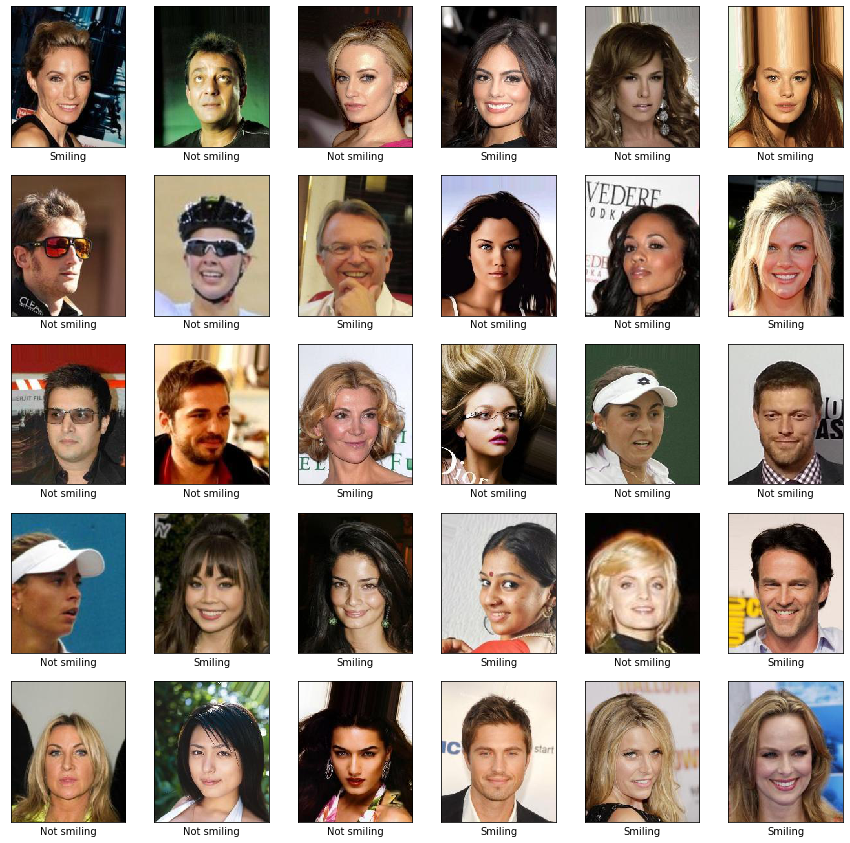

In [11]:
desc = {0: 'Not smiling',
        1: 'Smiling'}

plt.figure(figsize=(15,15))
for i in range(5):
    for j in range(6):
        plt.subplot(5, 6, (i*6)+j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = copy.copy(train_images[(i*6)+j])
        plt.imshow(image.reshape(HEIGHT, WIDTH, N_COLORS), cmap=plt.cm.binary)
        plt.xlabel(desc[train_target[(i*6)+j]])

# Exploratory data analysis

## Target distribution

In [9]:
vc = df_data.smiling.value_counts().to_frame()
vc.rename(columns={'smiling': 'value'}, inplace=True)

mask = vc.index == 0

vc.loc[::, 'target'] = 'Sonríe (1)'
vc.loc[mask, 'target'] = 'No sonríe (0)'

x = {
    'No sonríe (0)': vc[vc.index == 0].value.values[0],
    'Sonrie (1)': vc[vc.index == 1].value.values[0]
}

vc['angle'] = vc['value'] / vc['value'].sum() * 2 * pi
vc['color'] = ['#3182bd', '#e6550d']

p = figure(plot_height=350, title="Distribución del target", toolbar_location=None,
           tools="hover", tooltips="@target: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='target', source=vc)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

In [10]:
p = round((len(df_data[df_data.smiling == 1])/len(df_data))*100, 2)
print(f"La cantidad de personas que están sonriendo representan el {p}% del conjunto de datos.")
print(f"La cantidad de personas que no están sonriendo representan el {100-p}% del conjunto de datos.")

La cantidad de personas que están sonriendo representan el 48.89% del conjunto de datos.
La cantidad de personas que no están sonriendo representan el 51.11% del conjunto de datos.


Podemos observar que el target se encuentra casi perfectamente balanceado.

## Data volume

In [11]:
print("Cantidad total de imágenes:", len(df_data), "\n")
print("Cantidad en train:", len(df_train))
print("Cantidad en test:", len(df_test))
print("Cantidad en validation:", len(df_validation))

Cantidad total de imágenes: 10129 

Cantidad en train: 8138
Cantidad en test: 993
Cantidad en validation: 998


**Total data volumes**

In [12]:
make_data_volume(df_data, 0, tot=True)

,No,Yes
5_o_clock_shadow,8979,1150
arched_eyebrows,7427,2702
attractive,4947,5182
bags_under_eyes,8087,2042
bald,9933,196
bangs,8565,1564
big_lips,7688,2441
big_nose,7745,2384
black_hair,7640,2489
blond_hair,8627,1502


**Train volumes**

In [13]:
make_data_volume(df_data, 0)

,No,Yes
5_o_clock_shadow,7196,942
arched_eyebrows,5978,2160
attractive,3920,4218
bags_under_eyes,6488,1650
bald,7970,168
bangs,6879,1259
big_lips,6161,1977
big_nose,6234,1904
black_hair,6151,1987
blond_hair,6912,1226


**Test volumes**

In [14]:
make_data_volume(df_data, 1)

,No,Yes
5_o_clock_shadow,882,111
arched_eyebrows,734,259
attractive,507,486
bags_under_eyes,789,204
bald,983,10
bangs,844,149
big_lips,859,134
big_nose,739,254
black_hair,776,217
blond_hair,854,139


**Validation volumes**

In [15]:
make_data_volume(df_data, 2)

,No,Yes
5_o_clock_shadow,901,97
arched_eyebrows,715,283
attractive,520,478
bags_under_eyes,810,188
bald,980,18
bangs,842,156
big_lips,668,330
big_nose,772,226
black_hair,713,285
blond_hair,861,137


## Images type and structure

# Experiments

## Multi Layer Perceptron (MLP)

### Preprocesing

Para que esta red pueda entrenar necesitamos crear una lista de arrays donde cada array represente una imagen. 

Para ello, transformamos la estructura tridimensional del array de numpy (obtenido al leer las imagenes) en unidimencional: por cada imagen colocaremos sus pixeles de manera consecutiva obteniendo como resultado un array con los valores de color para cada pixel. Como cada pixel tiene 3 valores (RGB), tendremos 3 valores por pixel (cuánto de rojo, cuánto de verde y cuánto de azul). Considerenado además que las dimensiones de las imágenes usadas es de 178x218 pixeles, obtendremos en total 116412 valores por foto (128 x 218 x 3).

El formato por imágen sera el siguiente:

[r00, g00, b00, r01, g01, b01..., r217126, g217176, b217176, r217177, g217177, b217177]

*Anotación: valor del pixel rojo en la fila 0 columna 0, valor del pixel verde en la fila 0 columna 0, valor del pixel azúl en la fila 0 columna 0, etc.*

In [ ]:
def get_array_images_flatten(data):
    # Generamos el array de una sola dimensión con los pixeles para cada imagen
    X_images_MLP = []

    for image in data:
        aux_image = image.flatten()
        aux_image = aux_image / 255
        X_images_MLP.append(aux_image)

    return X_images_MLP

In [ ]:
train_images_MLP = get_array_images_flatten(train_images)
test_images_MLP = get_array_images_flatten(test_images)

In [ ]:
MLP_model = Sequential([
    Dense(200, activation='relu', input_shape=(INPUT_COLUMNS, )),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')

])

MLP_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [25]:
type(df_train.iloc[:, 0:1].values[0])

numpy.ndarray

In [27]:
type(np.array(test_images_MLP))

numpy.ndarray

In [28]:
history = MLP_model.fit(
    np.array(train_images_MLP), 
    np.array(train_target), 
    epochs=10,
    batch_size=128,
    validation_data=(
        np.array(test_images_MLP),
        np.array(test_target),
    )
)

Train on 8138 samples, validate on 993 samples
Epoch 1/10
8138/8138 [==============================] - 39s 5ms/step - loss: 2.1485 - accuracy: 0.5173 - val_loss: 0.6767 - val_accuracy: 0.5519
Epoch 2/10
8138/8138 [==============================] - 27s 3ms/step - loss: 0.7022 - accuracy: 0.5526 - val_loss: 0.6810 - val_accuracy: 0.6133
Epoch 3/10
8138/8138 [==============================] - 26s 3ms/step - loss: 0.6735 - accuracy: 0.5946 - val_loss: 0.6208 - val_accuracy: 0.7261
Epoch 4/10
8138/8138 [==============================] - 26s 3ms/step - loss: 0.6506 - accuracy: 0.6401 - val_loss: 0.5883 - val_accuracy: 0.6918
Epoch 5/10
8138/8138 [==============================] - 28s 3ms/step - loss: 0.6534 - accuracy: 0.5711 - val_loss: 0.6658 - val_accuracy: 0.5005
Epoch 6/10
8138/8138 [==============================] - 28s 3ms/step - loss: 0.6449 - accuracy: 0.6299 - val_loss: 0.5520 - val_accuracy: 0.7875
Epoch 7/10
8138/8138 [==============================] - 28s 3ms/step - loss: 0.6960

### Preprocesing cnn

In [ ]:
# Hacemos una copia de los datos para no modificar los originales y poderlos usar para otros modelos
train_images_MLP = copy.copy(train_images)
test_images_MLP = copy.copy(test_images)
validation_images_MLP = copy.copy(validation_images)

train_target_MLP = copy.copy(train_target)
test_target_MLP = copy.copy(test_target)
validation_target_MLP = copy.copy(validation_target)

In [14]:
# le damos formato a los conjuntos para poder operar con ellos luego
train_images = np.array(train_images).astype('uint8')
train_target = np.array(train_target).astype('uint8')

test_images = np.array(test_images).astype('uint8')
test_target = np.array(test_target).astype('uint8')

validation_images = np.array(validation_images).astype('uint8')
validation_target = np.array(validation_target).astype('uint8')

In [34]:
#Damos el formato necesario a cada conjunto para que sean comprensibles por la CNN
X_train = train_images.reshape([-1, N_COLORS, WIDTH, HEIGHT])
#X_test = test_images.reshape([-1, N_COLORS, WIDTH, HEIGHT])